In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats import proportion as prop

sns.set(rc={'figure.figsize':(12,8)})

In [146]:
users = pd.read_csv('ab_users_data.csv')
users.shape

(4337, 6)

In [147]:
orders = pd.read_csv('ab_orders.csv')
orders.shape

(4123, 3)

In [148]:
products = pd.read_csv('ab_products.csv')
products.shape

(87, 3)

In [149]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [150]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [151]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


<b>Основная</b> метрика - retention

<b>Guardrail</b> метрика - средний чек на клиента

<b>Основной</b> метрика:

$H_0$: Retention статзначимо не вырос

$H_1$: Retention вырос

Возьмем уровень значимости 0.05

<b>Guardrail</b> метрика:

$H_0$: Средний чек на клиента в обоих группах примерно равен

$H_1$: Средний чек снизился для теста

Возьмем уровень значимости 0.05

<b>Дополнительная</b> метрика:

$H_0$: Доля отказов для обоих групп равны

$H_1$: Доля отказов статистически различается

Возьмем уровень значимости 0.01

Сначала предобработаем данные

In [152]:
orders.product_ids = orders.product_ids.apply(lambda x: [int(i) for i in (x.strip('{}').split(', '))])

In [153]:
sums = []
for prods in orders.product_ids.values:
    s = 0
    for prod_id in prods:
        prod_price = int(products[products.product_id == prod_id].price)
        s += prod_price
    sums.append(s)
# sums

In [154]:
len(sums)

4123

In [155]:
orders['price_of_order'] = sums

In [156]:
orders.head()

,order_id,creation_time,product_ids,price_of_order
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",408
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]",250
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",309
3,1258,2022-08-26 00:02:56.000000,"[74, 6]",85
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",228


In [157]:
orders['creation_time'] = pd.to_datetime(orders['creation_time'])
users['time'] = pd.to_datetime(users['time'])
users['date'] = pd.to_datetime(users['date'])

Создадим фрэйм с уникальными пользователями и меткой вернулся ли он или нет

In [158]:
users.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
0,515
1,502


In [159]:
start_date = users\
    .query('action == "create_order"')\
    .groupby(['user_id', 'group'], as_index=False)\
    .agg({'date': 'min'})\
    .rename(columns={'date':'start_date'})

In [160]:
last_date = users\
    .query('action == "create_order"')\
    .groupby('user_id', as_index=False)\
    .agg({'date': 'max'})\
    .rename(columns={'date':'last_date'})

In [161]:
retention_df = start_date.merge(last_date, on='user_id')

In [162]:
retention_df['returned'] = (retention_df.last_date - retention_df.start_date > np.timedelta64(0, 'D')).map(int) 

In [163]:
retention_df.head()

,user_id,group,start_date,last_date,returned
0,964,0,2022-08-26,2022-08-26,0
1,965,1,2022-08-26,2022-09-04,1
2,966,0,2022-08-26,2022-08-26,0
3,967,1,2022-08-26,2022-08-28,1
4,968,0,2022-08-26,2022-08-31,1


Получился фрэйм с данными о юзере: id, группа, вернулся или нет.

### Основная метрика: retention

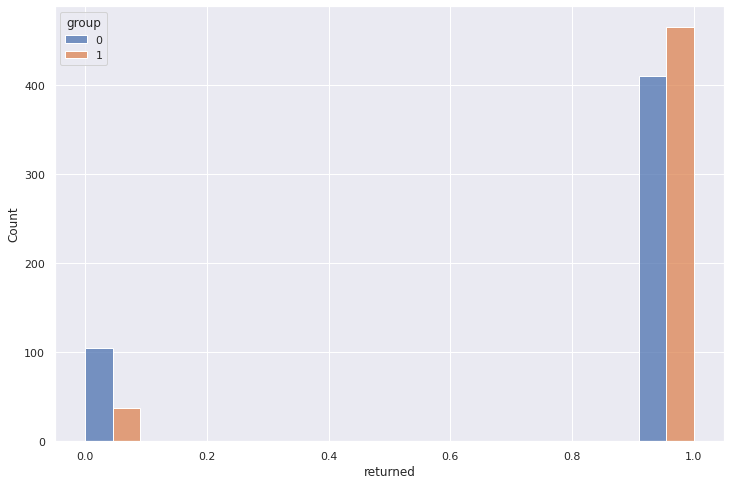

In [164]:
sns.histplot(data=retention_df, x='returned', hue='group', multiple="dodge");

In [165]:
retention_df.groupby('group', as_index=False).agg({'returned': 'mean'})

,group,returned
0,0,0.796117
1,1,0.926295


In [166]:
table = pd.crosstab(retention_df.group, retention_df.returned)
table

returned,0,1
group,,
0,105,410
1,37,465


Используем критерии Хи-квадрат и proportions ztest (Проверка пропорций на основе нормального (z) теста) с уровнем значимости 0.05

In [167]:
stats.chi2_contingency(table)

(34.7847561945611,
 3.682455219158407e-09,
 1,
 array([[ 71.90757129, 443.09242871],
        [ 70.09242871, 431.90757129]]))

In [168]:
count = [465, 410]
nobs = [502, 515]

In [169]:
prop.proportions_ztest(count, nobs, alternative='larger')

(5.988339300198773, 1.0599722733413194e-09)

Получив p-value у обоих тестов < 0.05, можно отклонить $H_0$ и принять $H_1$: Retention статзначимо вырос

Однако необходимо проверить остальные метрики

### Guardrail метрикa: средний чек по группам

In [171]:
full_df = users.merge(orders, on='order_id', how='left')

In [172]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4337 entries, 0 to 4336
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         4337 non-null   int64         
 1   order_id        4337 non-null   int64         
 2   action          4337 non-null   object        
 3   time            4337 non-null   datetime64[ns]
 4   date            4337 non-null   datetime64[ns]
 5   group           4337 non-null   int64         
 6   creation_time   4337 non-null   datetime64[ns]
 7   product_ids     4337 non-null   object        
 8   price_of_order  4337 non-null   int64         
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 338.8+ KB


In [173]:
full_df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,price_of_order
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",408
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",250
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",309
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]",85
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",228


In [174]:
full_df.drop(columns='product_ids').nunique()

user_id           1017
order_id          4123
action               2
time              4312
date                14
group                2
creation_time     4098
price_of_order     860
dtype: int64

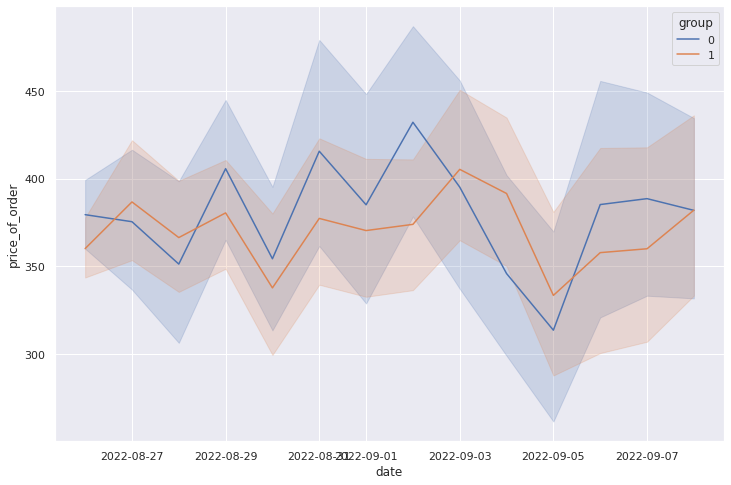

In [185]:
sns.lineplot(data=full_df, x='date', y='price_of_order', hue='group');

In [176]:
full_df.group.value_counts()

1    2646
0    1691
Name: group, dtype: int64

In [177]:
full_df.groupby('group', as_index=False).agg({'price_of_order':'mean'})

,group,price_of_order
0,0,379.968658
1,1,369.719577


Проверим гомогенность дисперсий

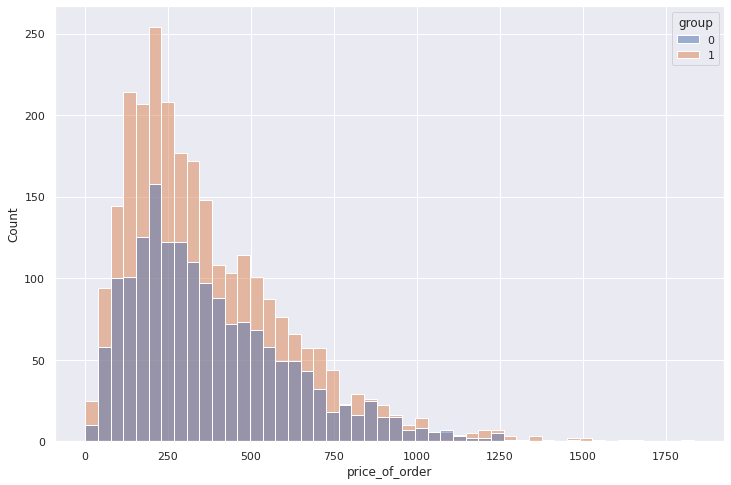

In [186]:
sns.histplot(data=full_df, x='price_of_order', hue='group');

In [179]:
test = full_df.query('group == 1')
control = full_df.query('group == 0')

In [180]:
stats.levene(test.price_of_order, control.price_of_order)

LeveneResult(statistic=0.001595685274597136, pvalue=0.9681379936029134)

Проверка на гомогенность дисперсий пройдена, врубаем T-test

Сделаем критерий левосторонним, так как нам интересен только тот случай, когда метрика упадет

In [181]:
stats.ttest_ind(test.price_of_order, control.price_of_order, alternative='less')

Ttest_indResult(statistic=-1.33861518351257, pvalue=0.09038308854397581)

Как видно p-value в результате сравнения средних чеков больше заданного уровня значимости, следовательно средние чеки изменились в пределах разумного. Guardrail метрика не упала. 

### Mетрикa отмены заказа

In [182]:
users.query('action == "cancel_order"').groupby('group', as_index=False).agg({'user_id':'nunique'})

,group,user_id
0,0,76
1,1,113


Опять же используем тест пропорций (proportions ztest) с двусторонней альтернативой

In [183]:
count = [113, 76]
nobs = [502, 515]

In [184]:
prop.proportions_ztest(count, nobs, alternative='two-sided')

(3.177764136331896, 0.0014841543364524168)

P-value больше уровня значимости (0.01), значит доля отказов статистически значимо не изменилась.

Проведя АБ-тест и посчитав несколько значимых метрик, мы поняли, что retention вырос, в то время как остальные метрики статистически значимо не изменились. Значит можно включать новую систему рекомендаций на всех пользователей.